In [1]:
using CUDA, Flux
CUDA.device!(0)
Threads.nthreads()

16

In [2]:
include("utils/train.jl")

In [3]:
using BitBasis
dev = gpu

gpu (generic function with 4 methods)

In [4]:
log(512)

6.238324625039508

In [5]:
function energy_Exact(nv, nh, Vvecs, Hvecs, rbm, J)
    enNumTot = []
    for i in 1:size(Vvecs,2) #2^nv
        rbm.v = repeat(Vvecs[:,i],1,size(Hvecs,2)) |> gpu
        rbm.h = Hvecs |> gpu
        # enNum = - (rbm.v' * (J.a |> cpu) + ((J.b' |> cpu) * rbm.h)' + diag(rbm.v' * (J.w |> cpu) * rbm.h))
        enNum = H(rbm, J)
        append!(enNumTot, enNum)
    end
    enNumTot
end

energy_Exact (generic function with 1 method)

In [6]:
function thermComparison(; samples = 50, oneonone = true, nvMax=16, nhMin = 0, norm=false, Gsamps=10, β=1)    
    eNumerical = zeros(1,2+samples) #[0 0 0]
    eDiag = zeros(1,2+samples)
    eRand = zeros(1,2+samples)
    eGibbs = zeros(1,2+samples)
    
    fNumerical = zeros(1,2+samples) #[0 0 0]
    fDiag = zeros(1,2+samples)
    fRand = zeros(1,2+samples)
    fGibbs = zeros(1,2+samples)
    
    sNumerical = zeros(1,2+samples) #[0 0 0]
    sDiag = zeros(1,2+samples)
    sRand = zeros(1,2+samples)
    sGibbs = zeros(1,2+samples)
    
    for nv in 1:nvMax 
        if nhMin == 0
            nv0 = nv
        else
            nv0 = nhMin
        end
        for nh in nv0:nv
            @info "nv=$nv , nh=$(nh)"
            # nh=nv
            Vvecs = bitarray(collect(0:2^nv-1), nv)
            Hvecs = bitarray(collect(0:2^nh-1), nh);
        
            Vrand = randn(nv, nv)
            Hrand = randn(nh, nh);
        
            enNumL, enRBML, enRandL, enGibbsL = [], [], [], []
        
            FNumL, FRBML, FRandL, FGibbsL = [], [], [], []
        
            # SNumL, SRBML, SRandL = [], [], []
            for s in 1:samples
                rbm, J, m, hparams, rbmZ = initModel(nv=nv, nh=nh, batch_size=10, lr=1.5, t=10, gpu_usage = true, optType="Adam")
                # Random.seed!(1234);
                # rbm, J, m, hparams, opt = train(0, epochs=1, nv=nv, nh=nh, batch_size=500, lr=0.0001, t=1, plotSample=false, 
                        # annealing=false, learnType="CD", β=1, β2 = 1/1, gpu_usage = true, t_samp = 1, num=1, optType="Adam", 
                        # numbers=[0,1,2,3,4,5,6,7,8,9], savemodel=false, snapshot=1)
        
                #Exact
                rbm.v = Vvecs |> gpu
                rbm.h = Hvecs |> gpu
                if norm
                    rbm.v = rbm.v ./ (sum(rbm.v, dims=1) .+ 1e-9)
                    rbm.h = rbm.h ./ (sum(rbm.h, dims=1) .+ 1e-9)
                end
                if oneonone
                    enNum = H(rbm, J)
                else
                    enNum = energy_Exact(nv, nh, rbm.v, rbm.h, rbm, J)
                end
                append!(enNumL, sum(exp.(- enNum) .* enNum)/sum(exp.(- enNum)))
                append!(FNumL, -log(sum(exp.(- enNum))) )
                # append!(SNumL, enNumL - FNumL )
        
                #Diag
                H_eff = H_effective(J, hparams; dev)
                F = LinearAlgebra.svd(H_eff, full=true);
                # append!(enRBML, sum(exp.(-F.S) .* F.S)/sum(exp.(-F.S)))
                # append!(FRBML, -log(sum(exp.(- F.S))) )
                rbm.h = Array{Float32}(sign.(rand(hparams.nh, hparams.nh) |> dev .< σ.(β .* (F.V)))) |> dev
                rbm.v = Array{Float32}(sign.(rand(hparams.nv, hparams.nv) |> dev .< σ.(β .* (F.U)))) |> dev
                if norm
                    rbm.v = rbm.v ./ (sum(rbm.v, dims=1) .+ 1e-9)
                    rbm.h = rbm.h ./ (sum(rbm.h, dims=1) .+ 1e-9)
                end
                if oneonone
                    enNum = H(rbm, J)
                else
                    enNum = energy_Exact(nv, nh, rbm.v, rbm.h, rbm, J)
                end
                append!(enRBML, sum(exp.(- enNum) .* enNum)/sum(exp.(- enNum)))
                append!(FRBML, -log(sum(exp.(- enNum))) )
                # append!(SRBML, enRBML - FRBML )
                
                #Random Gaussian vectors
                rbm.v = Vrand |> gpu
                rbm.h = Hrand |> gpu
                if norm
                    rbm.v = rbm.v ./ (sum(rbm.v, dims=1) .+ 1e-9)
                    rbm.h = rbm.h ./ (sum(rbm.h, dims=1) .+ 1e-9)
                end
                if oneonone
                    enNum = H(rbm, J)
                else
                    enNum = energy_Exact(nv, nh, rbm.v, rbm.h, rbm, J)
                end
                append!(enRandL, sum(exp.(- enNum) .* enNum)/sum(exp.(- enNum)))
                append!(FRandL, -log(sum(exp.(- enNum))) )
                # append!(SRandL, enRandL - FRandL )

                #Gibbs sampling vectors
                rbm.v = Vrand |> gpu
                for i in 1:Gsamps
                    rbm.h = Array{Float32}(sign.(rand(hparams.nh, size(Vrand,2)) |> dev .< σ.(β .* (J.w' * rbm.v .+ J.b)))) |> dev
                
                    rbm.v = Array{Float32}(sign.(rand(hparams.nv, size(Vrand,2)) |> dev .< σ.(β .* (J.w * rbm.h .+ J.a)))) |> dev 
                end
                if norm
                    rbm.v = rbm.v ./ (sum(rbm.v, dims=1) .+ 1e-9)
                    rbm.h = rbm.h ./ (sum(rbm.h, dims=1) .+ 1e-9)
                end
                if oneonone
                    enNum = H(rbm, J)
                else
                    enNum = energy_Exact(nv, nh, rbm.v, rbm.h, rbm, J)
                end
                append!(enGibbsL, sum(exp.(- enNum) .* enNum)/sum(exp.(- enNum)))
                append!(FGibbsL, -log(sum(exp.(- enNum))) )
                # append!(SRandL, enRandL - FRandL )
            end
        
            fNumerical = vcat(fNumerical, [nv nh FNumL']) 
            fDiag = vcat(fDiag, [nv nh FRBML'])
            fRand = vcat(fRand, [nv nh FRandL'])
            fGibbs = vcat(fGibbs, [nv nh FGibbsL'])
        
            sNumerical = vcat(sNumerical, [nv nh (enNumL .- FNumL)']) 
            sDiag = vcat(sDiag, [nv nh (enRBML .- FRBML)'])
            sRand = vcat(sRand, [nv nh (enRandL .- FRandL)'])
            sGibbs = vcat(sGibbs, [nv nh (enGibbsL .- FGibbsL)'])
        
            eNumerical = vcat(eNumerical, [nv nh enNumL']) 
            eDiag = vcat(eDiag, [nv nh enRBML'])
            eRand = vcat(eRand, [nv nh enRandL'])
            eGibbs = vcat(eGibbs, [nv nh enGibbsL'])
        end
    end
    fNumerical = fNumerical[2:end, :]
    fDiag = fDiag[2:end, :]
    fRand = fRand[2:end, :];
    fGibbs = fGibbs[2:end, :];
    
    sNumerical = sNumerical[2:end, :]
    sDiag = sDiag[2:end, :]
    sRand = sRand[2:end, :];
    sGibbs = sGibbs[2:end, :];
    
    eNumerical = eNumerical[2:end, :]
    eDiag = eDiag[2:end, :]
    eRand = eRand[2:end, :];
    eGibbs = eGibbs[2:end, :];
    return fNumerical, fDiag, fRand, fGibbs, eNumerical, eDiag, eRand, eGibbs, sNumerical, sDiag, sRand, sGibbs
end

thermComparison (generic function with 1 method)

In [207]:
fNumerical, fDiag, fRand, fGibbs, eNumerical, eDiag, eRand, eGibbs, sNumerical, sDiag, 
    sRand, sGibbs = thermComparison(samples = 100, oneonone = false, nvMax=10, nhMin = 1, norm=false, Gsamps=1);


[ Info: nv=1 , nh=1
[ Info: nv=2 , nh=1
[ Info: nv=2 , nh=2
[ Info: nv=3 , nh=1
[ Info: nv=3 , nh=2
[ Info: nv=3 , nh=3
[ Info: nv=4 , nh=1
[ Info: nv=4 , nh=2
[ Info: nv=4 , nh=3
[ Info: nv=4 , nh=4
[ Info: nv=5 , nh=1
[ Info: nv=5 , nh=2
[ Info: nv=5 , nh=3
[ Info: nv=5 , nh=4
[ Info: nv=5 , nh=5
[ Info: nv=6 , nh=1
[ Info: nv=6 , nh=2
[ Info: nv=6 , nh=3
[ Info: nv=6 , nh=4
[ Info: nv=6 , nh=5
[ Info: nv=6 , nh=6
[ Info: nv=7 , nh=1
[ Info: nv=7 , nh=2
[ Info: nv=7 , nh=3
[ Info: nv=7 , nh=4
[ Info: nv=7 , nh=5
[ Info: nv=7 , nh=6
[ Info: nv=7 , nh=7
[ Info: nv=8 , nh=1
[ Info: nv=8 , nh=2
[ Info: nv=8 , nh=3
[ Info: nv=8 , nh=4
[ Info: nv=8 , nh=5
[ Info: nv=8 , nh=6
[ Info: nv=8 , nh=7
[ Info: nv=8 , nh=8
[ Info: nv=9 , nh=1
[ Info: nv=9 , nh=2
[ Info: nv=9 , nh=3
[ Info: nv=9 , nh=4
[ Info: nv=9 , nh=5
[ Info: nv=9 , nh=6
[ Info: nv=9 , nh=7
[ Info: nv=9 , nh=8
[ Info: nv=9 , nh=9
[ Info: nv=10 , nh=1
[ Info: nv=10 , nh=2
[ Info: nv=10 , nh=3
[ Info: nv=10 , nh=4
[ Info: nv=10 , 

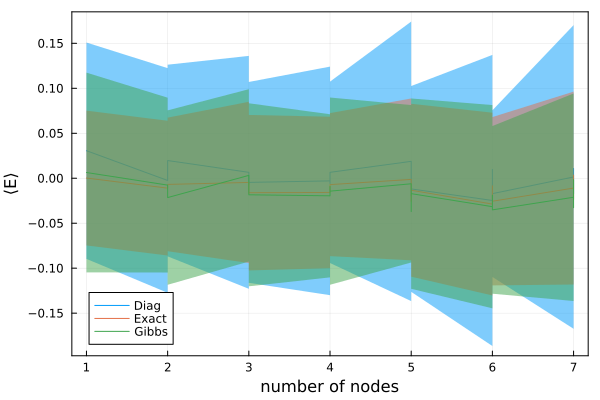

In [206]:
plot(eDiag[:,1],mean(eDiag[:,3:end], dims=2)[:], ribbon=std(eDiag[:,3:end], dims=2)[:], label="Diag")
# plot!(eRand[:,1],mean(eRand[:,3:end], dims=2)[:], ribbon=std(eRand[:,3:end], dims=2)[:], label="RandN")
plot!(eNumerical[:,1],mean(eNumerical[:,3:end], dims=2)[:], ribbon=std(eNumerical[:,3:end], dims=2)[:], label="Exact")
plot!(eGibbs[:,1],mean(eGibbs[:,3:end], dims=2)[:], ribbon=std(eGibbs[:,3:end], dims=2)[:], label="Gibbs")
plot!(xlabel="number of nodes", ylabel="⟨E⟩", frame=:box, legend=:bottomleft)

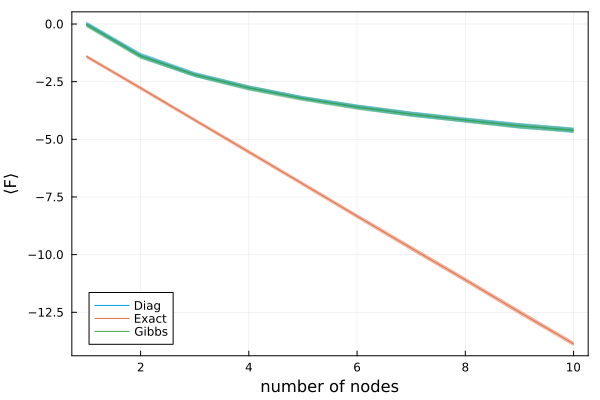

In [187]:
plot(fDiag[:,1],mean(fDiag[:,3:end], dims=2)[:], ribbon=std(fDiag[:,3:end], dims=2)[:], label="Diag")
# plot!(fRand[:,1],mean(fRand[:,3:end], dims=2)[:], ribbon=std(fRand[:,3:end], dims=2)[:], label="RandN")
plot!(fNumerical[:,1],mean(fNumerical[:,3:end], dims=2)[:], ribbon=std(fNumerical[:,3:end], dims=2)[:], label="Exact")
plot!(fGibbs[:,1],mean(fGibbs[:,3:end], dims=2)[:], ribbon=std(fGibbs[:,3:end], dims=2)[:], label="Gibbs")
plot!(xlabel="number of nodes", ylabel="⟨F⟩", frame=:box, legend=:bottomleft)

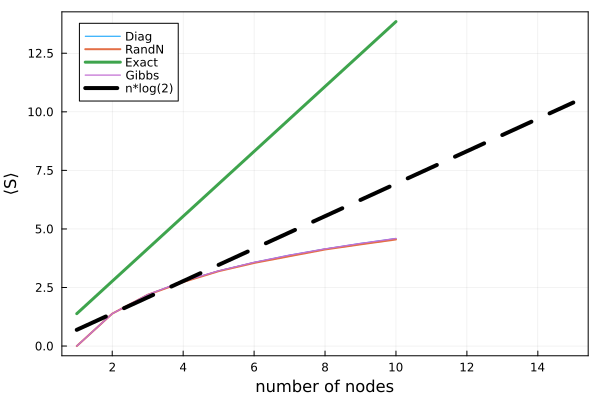

In [188]:
plot(sDiag[:,1],mean(sDiag[:,3:end], dims=2)[:], ribbon=std(sDiag[:,3:end], dims=2)[:], label="Diag")
plot!(sRand[:,1],mean(sRand[:,3:end], dims=2)[:], ribbon=std(sRand[:,3:end], dims=2)[:], label="RandN", lw=2)
plot!(sNumerical[:,1],mean(sNumerical[:,3:end], dims=2)[:], ribbon=std(sNumerical[:,3:end], dims=2)[:], label="Exact", lw=3)
plot!(sGibbs[:,1],mean(sGibbs[:,3:end], dims=2)[:], ribbon=std(sGibbs[:,3:end], dims=2)[:], label="Gibbs", lw=1.3)
plot!(1:15,collect(1:15) .* log(2) .* 1, label="n*log(2)", ls=:dash, lw=4, c=:black)
plot!(xlabel="number of nodes", ylabel="⟨S⟩", frame=:box, legend=:topleft)

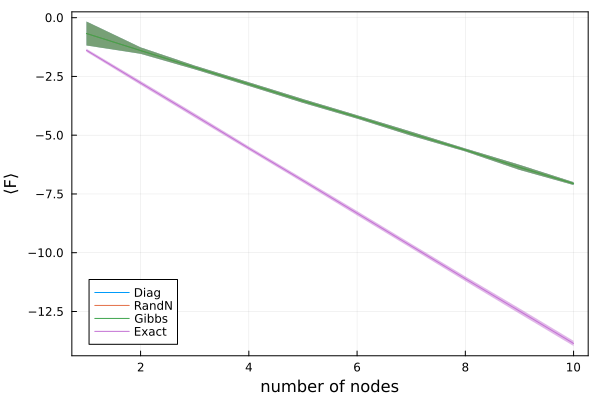

In [135]:
plot(fDiag[:,1],mean(eDiag[:,3:end], dims=2)[:] .- collect(1:size(eDiag,1)) .* log(2) .* 1, ribbon=std(eDiag[:,3:end], dims=2)[:], label="Diag")
plot!(fRand[:,1],mean(eRand[:,3:end], dims=2)[:] .- collect(1:size(eDiag,1)) .* log(2) .* 1, ribbon=std(eRand[:,3:end], dims=2)[:], label="RandN")
plot!(fGibbs[:,1],mean(eGibbs[:,3:end], dims=2)[:] .- collect(1:size(eGibbs,1)) .* log(2) .* 1, ribbon=std(eGibbs[:,3:end], dims=2)[:], label="Gibbs")
plot!(fNumerical[:,1],mean(fNumerical[:,3:end], dims=2)[:], ribbon=std(fNumerical[:,3:end], dims=2)[:], label="Exact")
plot!(xlabel="number of nodes", ylabel="⟨F⟩", frame=:box, legend=:bottomleft)

In [1]:
#Trained model

In [7]:
modelName = "CD-500-R1"
rbm, J, m, hparams, opt = loadModel(modelName, gpu);

[ Info: /home/javier/Projects/RBM/Results/models/CD-500-R1


┌ Warning: Performing scalar indexing on task Task (runnable) @0x00007fe2c351a720.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore are only permitted from the REPL for prototyping purposes.
│ If you did intend to index this array, annotate the caller with @allowscalar.
└ @ GPUArraysCore ~/.julia/packages/GPUArraysCore/HaQcr/src/GPUArraysCore.jl:106
┌ Warning: Diagonalization of effective H prompted false
└ @ Main ~/Projects/RBM/utils/en.jl:28
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/package

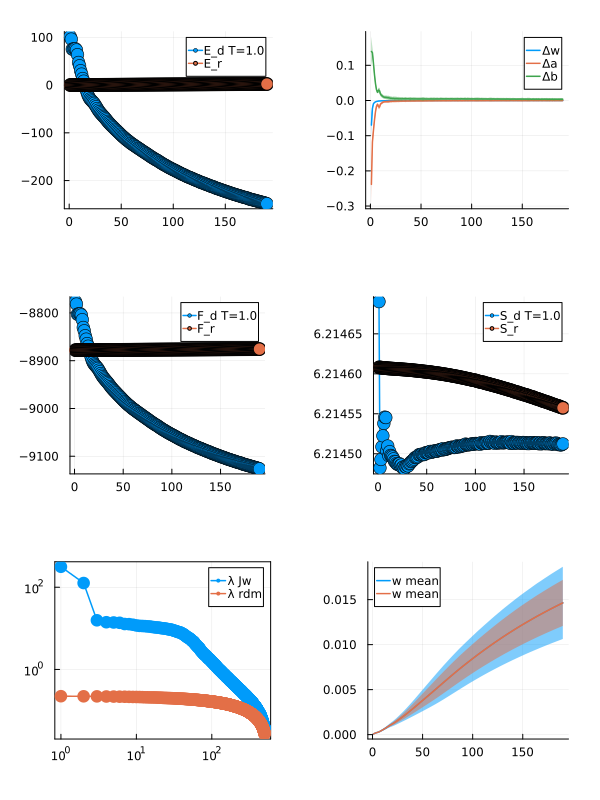

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191


In [8]:
genSample(rbm, J, hparams, m; num = 100, t = 1, β = 1, mode = "results", dev, dict=0)

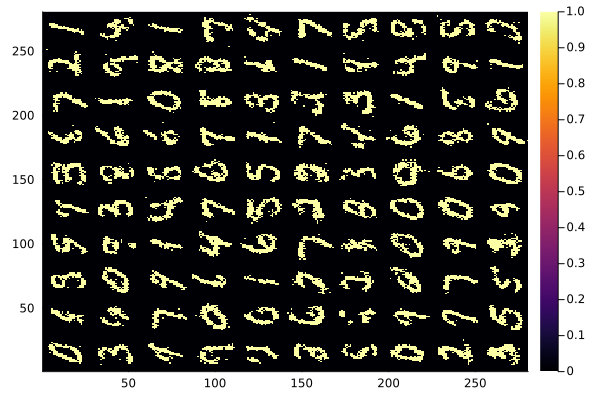

In [9]:
genSample(rbm, J, hparams, m; num = 100, t = 5000, β = 1, mode = "test", dict=0, dev)

In [10]:
nv, nh = 28*28, 500
β = 1
#Diag
H_eff = H_effective(J, hparams; dev)
F = LinearAlgebra.svd(H_eff, full=false);
# append!(enRBML, sum(exp.(-F.S) .* F.S)/sum(exp.(-F.S)))
# append!(FRBML, -log(sum(exp.(- F.S))) )
rbm.h = Array{Float32}(sign.(rand(hparams.nh, hparams.batch_size) |> dev .< σ.(β .* (F.V)))) |> dev
rbm.v = Array{Float32}(sign.(rand(hparams.nv, hparams.batch_size) |> dev .< σ.(β .* (F.U)))) |> dev
# if norm
#     rbm.v = rbm.v ./ (sum(rbm.v, dims=1) .+ 1e-9)
#     rbm.h = rbm.h ./ (sum(rbm.h, dims=1) .+ 1e-9)
# end
# if oneonone
enNum = H(rbm, J)
# else
# enNum = energy_Exact(nv, nh, rbm.v, rbm.h, rbm, J)
# end
@info sum(exp.(- enNum) .* enNum)/sum(exp.(- enNum))
@info -log(sum(exp.(- enNum))) 

┌ Warning: Diagonalization of effective H prompted false
└ @ Main ~/Projects/RBM/utils/en.jl:28
[ Info: NaN
[ Info: Inf


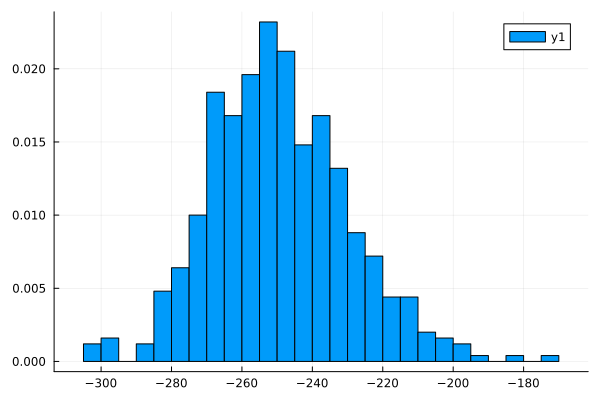

In [16]:
plot(enNum, st=:histogram, bins=40, normalized=true)
# plot!(2500:3500, x->1/√(2π*180^2) * exp(-(x-3000)^2/(2*180^2)), lw=2)

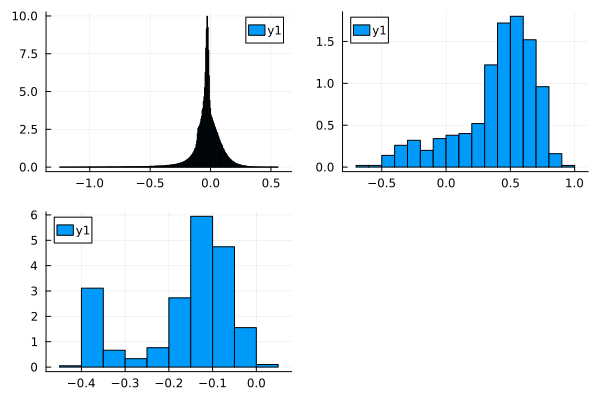

In [17]:
pp1 = plot(J.w[:] |> cpu, st=:histogram, normalize=true)
pp2 = plot(J.b |> cpu, st=:histogram, normalize=true)
pp3 = plot(J.a |> cpu, st=:histogram, normalize=true)
plot(pp1,pp2,pp3)

In [18]:
#Energy
minimum(enNum)
#FRee energy
# minimum(enNum) - log(500)
F = LinearAlgebra.svd(J.w, full=false);

In [19]:
F.S

500-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 21.592924
 15.146366
 14.361917
 13.933037
 13.6513605
 12.802021
 12.518117
 11.921028
 11.625474
 11.559499
 11.436284
 11.293265
 11.160661
  ⋮
  0.043145053
  0.04247217
  0.04119745
  0.040508453
  0.04025282
  0.03910127
  0.038415894
  0.037777483
  0.037428558
  0.03595959
  0.03445214
  0.033047557

In [12]:
#Gibbs sampling vectors
Gsamps = 10000
Vrand = randn(nv, hparams.batch_size)
rbm.v = Vrand |> gpu
enSamp = []
for i in 1:Gsamps
    rbm.h = Array{Float32}(sign.(rand(hparams.nh, size(Vrand,2)) |> dev .< σ.(β .* (J.w' * rbm.v .+ J.b)))) |> dev

    rbm.v = Array{Float32}(sign.(rand(hparams.nv, size(Vrand,2)) |> dev .< σ.(β .* (J.w * rbm.h .+ J.a)))) |> dev 
    enNum = H(rbm, J)
    push!(enSamp, minimum(enNum))
end
# if norm
#     rbm.v = rbm.v ./ (sum(rbm.v, dims=1) .+ 1e-9)
#     rbm.h = rbm.h ./ (sum(rbm.h, dims=1) .+ 1e-9)
# end
# if oneonone
# enNum = H(rbm, J)
# else
    # enNum = energy_Exact(nv, nh, rbm.v, rbm.h, rbm, J)
# end
@info sum(exp.(- enNum) .* enNum)/sum(exp.(- enNum))
@info -log(sum(exp.(- enNum)))

[ Info: NaN
[ Info: -Inf


In [13]:
minimum(enNum)

-302.26498f0

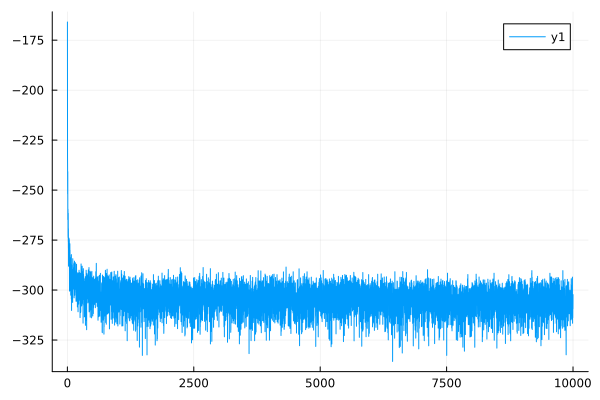

In [14]:
plot(enSamp)

In [56]:
minimum(enNum)

2466.842f0

In [60]:
mean(enSamp[end-5000,end]) - log(500)

-304.0597008718597

In [61]:
28*28 * log(2)

543.4273895589971

In [64]:
F.S

500-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 314.96024
 126.639915
  15.704603
  14.089542
  13.890981
  13.644157
  12.744821
  12.646869
  12.245454
  11.7621355
  11.495075
  11.410136
  11.319832
   ⋮
   0.043339968
   0.04284264
   0.04163475
   0.04066356
   0.040302128
   0.039753627
   0.038718875
   0.038209897
   0.03795975
   0.036339153
   0.035040323
   0.033418193